# Task 4.2P
SIT796  
Deakin University  
Joshua Sansom-Sherwill  
220013964  
Public URL: https://github.com/sansomguy/OnTrack_Public/blob/main/Task_4_2P.ipynb  

---

## 1. Introduction
In this essay I will describe how I have implemented the off-policy Monte Carlo control to balance exploration with exploitation in order to define an approximately optimal policy.

I will also describe how the off-policy and on-policy algorithm and results differ.

## 2. Off-Policy Iteration
Off-policy control is a method for exploring the state space without skewing the "optimality" of the policy being learned with suboptimal actions during exploration.

In section C.2 I have defined our behaviour policy. 
> A behaviour policy is any policy where $if\ \pi(a|s) > 0\ then\ b(a|s) > 0$ (*coverage property*) \[1\]. 

The behaviour policy can be any policy that satisfies the coverage property, therefore I have just used an epsilon-greedy behaviour policy with a constant $\epsilon = 0.2$ and the greedy policy component is the target policy.

Within C.2 is also the implementation of an iteration of a black jack episode.

Section C.3 is where we define the policy improvement using an off-policy algorithm called "Weighted Importance Sampling". The exact implementation is defined as per Sutton and Barton \[2\].

The target state action value function is updated based on a weighted sampling of the behaviour policy trajectory.  

> $Q(s_t, a_t) \leftarrow Q(s_t, a_t) + W/C(s_t,a_t)[G - Q(s_t,a_t)]$  
> Where $W$ is the ratio of probabilistic similarity of the behaviour trajectory with the targety policy. And $C(s_t, a_t)$ is the sum of all $W$ for a specific state-action pair.   

This is the main distinction between off-policy and on-policy. When looking at the on-policy implementation in C.8 (from practical 4), we can see that it updates based only on an $alpha$ ("learning rate") value. The off policy learning only updates the target policy based on the similarity of trajectory to the behaviour policy. This means that the learning of the state value function is less affected by suboptimal exploration in off-policy iteration vs on-policy iteration.

> __Importantly__, the $W$ value is only updated $IFF$ the $\pi(a|s_t)$ has not changed.  
Also, given $\pi$ is by definition greedy, the update to $W$ is written as $ W \leftarrow W \times ((\pi(a|s) = 1)/b(a|s)) \Rightarrow W \leftarrow W/b(a|s)$.

My implementation uses two dictionaries for the state-value function $Q$, and the sum of $W_k$ variable in $C$. They are both named according to the pseudo code in Sutton & Barto \[2\].

## 3. Off-policy & On-Policy Comparison

#### 3.1 State-Value Distributions
Sections **C.5 and C.8** visualize learned state-values for both Off-policy and On-policy iteration strategies. While it's hard to compare each strategy quantitatively from these visualizations, we can see that the off-policy solution has a smoother grandient and less distinction between neighboring state which might imply more exploration.

#### 3.2 Policy Distributions
In sections **C.6 and C.8** we see the policies visualized. There is a large overlap between which actions are taken within the states, however, there is distinction where Off-policy learning seems to have "tighter" clustering of its actions. This is likley because the Off-policy learning explores more often over some of these low determinstic states-action pairs and removes some of the stochasticity of these outcomes.

#### 3.3 Learning Rate & Exploration
Another point of comparison we can see is the average reward over all the episodes per strategy visualized in section **C.10**. The off-policy "behaviour policy" while initially shows some positive progress, begins to plateau. In contrast the On-policy method takes a longer time to show progress, likely due to a large initial epsilon value, and then, as epsilon decreases over time, the average reward plateaus at a much higher average reward because of a higher exploitation to exploration ratio. This demonstrates that exploration persists in Off-Policy iteration.  

We can also see that the rate at which on-policy learning becomes optimal is higher than off-policy iteration. When the state space is very large and the potential for reward is higher through exploration, then off-policy will have a higher probability of discovering an optimal policy.

#### 3.4 Optimality
Our last point of comparison is the wins ratios for each strategy in C.7 and C.9. Both win ratios are approximately 43%. Given what we know about Black Jack, these win ratios imply that both policies are approximately optimal ($\pi \approx \pi^*$).

Given what we have shown above (and below) about the improved exploration of the off-Policy strategy, I would tend to utilize the off-policy strategy as the preferred approach for finding optimal policies.

## 4. References
1. Richard S. Sutton, Andrew G. Barto, "Introduction in Reinforcement Learning: an introduction", 2nd ed. Cambridge, Massachusetts; London, England: The MIT Press, 2018, ch. 5, pp. 103
1. Richard S. Sutton, Andrew G. Barto, "Introduction in Reinforcement Learning: an introduction", 2nd ed. Cambridge, Massachusetts; London, England: The MIT Press, 2018, ch. 5, pp. 111

## C1. Bootstrapping Code
Some code for bootstrapping the work down in the following sections.
> *This code was provided as part of practical 4.*

In [92]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict

env = gym.make('Blackjack-v0')

In [93]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
'''
  :: Code given in Practical 4
  This code is used to render a 3D plot of the dealer vs player expected reward
  at each state for both "usable Ace" and "not-usable Ace" game modes
'''
def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()


## C.2 Behaviour Policy
Below we implement our behaviour policy. In this case it is just the $\epsilon$-greedy version of the target policy.

> Notice "generate_behaviour_policy_episode" which will explore an episode using the behaviour policy and return the results of the episode.

In [94]:

'''
  Given we are using a behavior policy that is based on an epsilon greedy version of our target policy
  we know that the probability of a state given an action is at least epsilon/|A(s)|
  We also know that our probability of choosing the optimal action is equal to (1 - epslion) + (epsilon/|A(s)|)
'''
def get_behaviour_probs(Q_s, epsilon, Q_s_actions_count):
    policy_s = np.ones(Q_s_actions_count) * epsilon / Q_s_actions_count
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / Q_s_actions_count)
    return policy_s

def generate_behaviour_policy_episode(env, Q, epsilon):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = env.reset()
    while True:
      # in order to ensure exploration
      # Choose action based on probabilities of behaviour policy
      action = np.random.choice(np.arange(env.action_space.n), p=get_behaviour_probs(Q[state], epsilon, env.action_space.n))
      
      next_state, reward, done, info = env.step(action)

      episode.append((state, action, reward))
      state = next_state
      if done:
          break
    return episode


## C.3 Target Policy Improvement
This code defines how we update our target policy based using weighted importance sampling for an "off-policy" improvement \[1\].

In [95]:
''' 
  update our target policy using off-policy update
  from our behaviour policy driven episode 
'''
def update_target_policy(env, episode, Q, C, gamma, epsilon):
  W = 1
  states,actions,rewards = zip(*episode)
  discounts = np.array([gamma**i for i in range(len(rewards)+1)])
  for i,state in enumerate(states):
    state = states[i]
    action = actions[i]
    # Get total reward with respect to discounting
    G = sum(rewards[i:]*discounts[:-(1+i)])
    
    # update the sum of all importance sampling ratios for a specific action
    C[state][action] = C[state][action] + W
    # update target policy using weighted importance sampling
    Q[state][action] = Q[state][action] + (W/C[state][action])*(G - Q[state][action])

    # if the behaviour policy has deviated from the optimal policy
    # then start another episode as described in Stutton and Barto [1]
    if not np.argmax(Q[state]) == action:
      break
    # update the behavior policy weighting if we our policies are still closely aligned
    W = W/get_behaviour_probs(Q[state], epsilon, env.action_space.n)[action]

## C.4 Off-Policy Monte Carlo Control
Based heavily on the pseudo code given in Sutton & Barto \[2\], the code below is our Monte Carlo control for updating our target policy.

It uses the methods defined above in order to perform policy iteration & improvement for the black jack environment. After which, the policy and state-value functions are both returned.

In [96]:
def mc_off_policy_control(env, num_episodes):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    epsilon = 0.2
    gamma=0.9
    average_rewards = []

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
          print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
          sys.stdout.flush()

        # generates an episode from following the epsilon-greedy policy
        episode = generate_behaviour_policy_episode(env, Q, epsilon)
        update_target_policy(env, episode, Q, C, gamma, epsilon)
        _, _, rewards = zip(*episode)
        average_rewards.append(np.mean(rewards))

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, average_rewards

## C.5 Policy Improvement & Visualization
Below we perform the Monte Carlo control policy iteration algorithms, followed by a visualization of the state value function with respect to both dealer and player hands in black jack.

In [97]:
# obtain the estimated optimal policy and action-value function
policy, Q, average_rewards = mc_off_policy_control(env, 2*500000)

Episode 1000000/1000000.

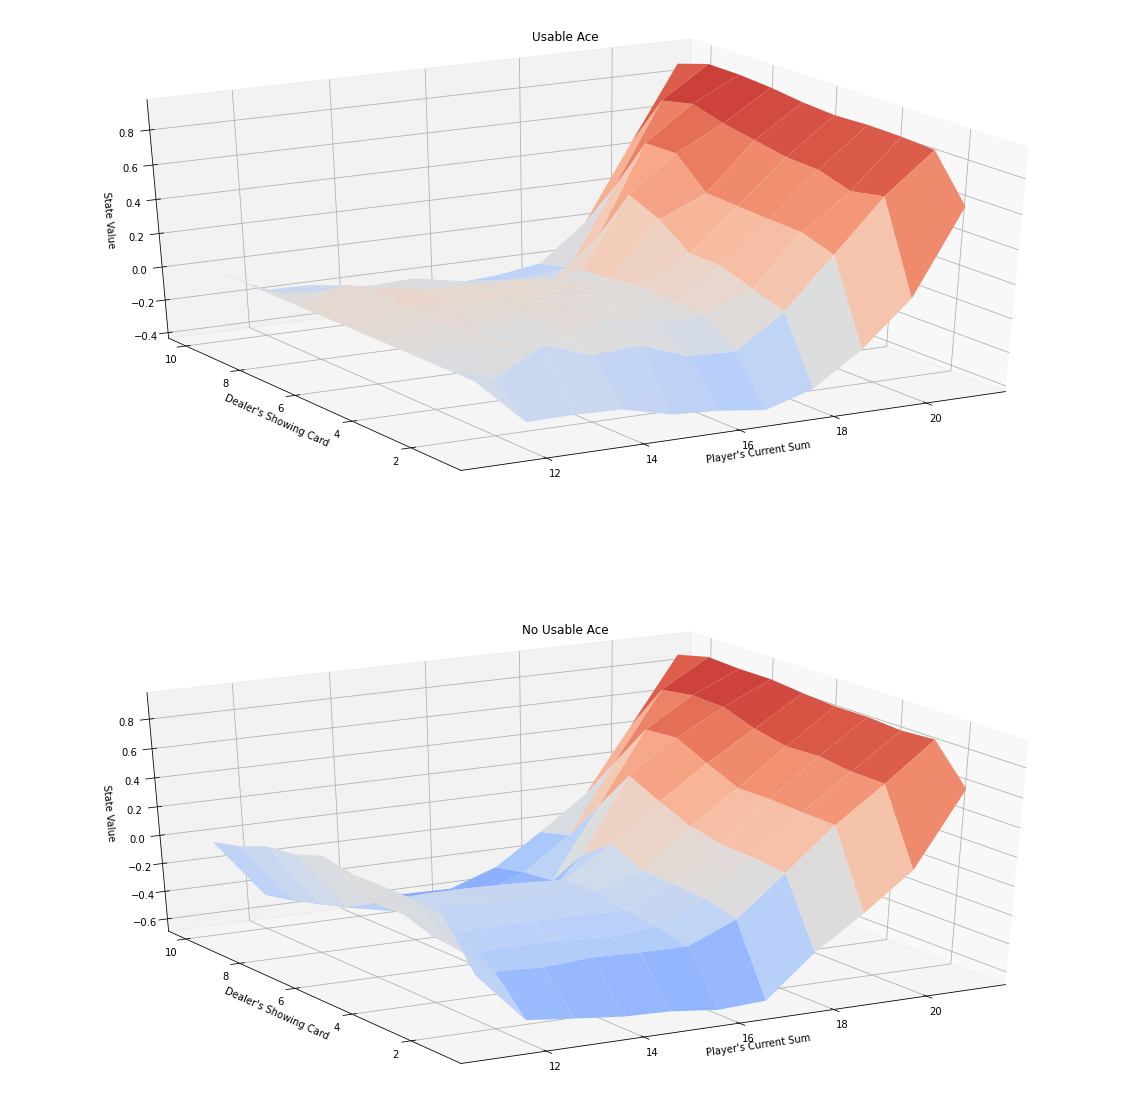

In [98]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

## C.6 Policy Visualization

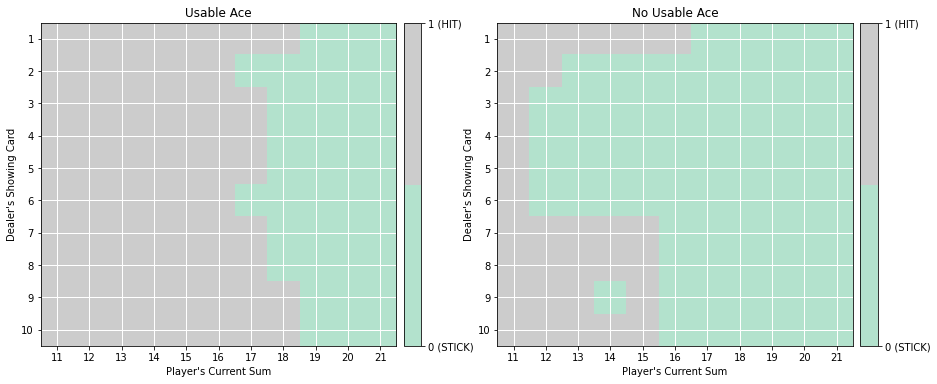

In [99]:
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

# plot the policy
plot_policy(policy)

## C.7 Tests & Results
Below we run our policy over many episodes of black jack, using our target policy to track its success rate.

> We can see an approximate 43% success rate using our policy.

In [114]:
wins = 0
max_episodes = 10000
for i_episode in range(max_episodes):
    state = env.reset()
    while True:
        action = np.argmax(Q[state])
        next_state, reward, done, info = env.step(action)
        state = next_state
        if done:
            if reward > 0:
              wins += 1
            break

print("Win Rate: {}%".format((wins/max_episodes) * 100))

Win Rate: 43.34%


## C.8 Practical 4
Below is the best performing policy from practical 4 using on-policy learning.

> *All code copied from Practical 4*  

In [66]:
def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # obtains the action probabilities corresponding to epsilon-greedy policy
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s
  
''' 
Now we will use this get_probs func in generating the episode. 
Note that we are no longer using the stochastic policy we started with, instead building upon it in an epsilon greedy way.
'''
def generate_episode_from_Q(env, Q, epsilon, nA):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

''' 
Finally Q values are approximated by taking average of corresponding returns.
But instead we can write it using incremental mean and constant alpha.
As we are using constant alpha we need not keep a track of N-table, ie how many times we visited that state.
''' 

def update_Q(env, episode, Q, alpha, gamma):
    # updates the action-value function estimate using the most recent episode 
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    average_rewards = []
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
        _,_,rewards = zip(*episode)
        average_rewards.append(np.mean(rewards))
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, average_rewards

In [67]:
# obtain the estimated optimal policy and action-value function
onpolicy, Q_onpolicy, onpolicy_rewards = mc_control(env, 500000, 0.015)

# obtain the corresponding state-value function
V_onpolicy = dict((k,np.max(v)) for k, v in Q_onpolicy.items())

Episode 500000/500000.

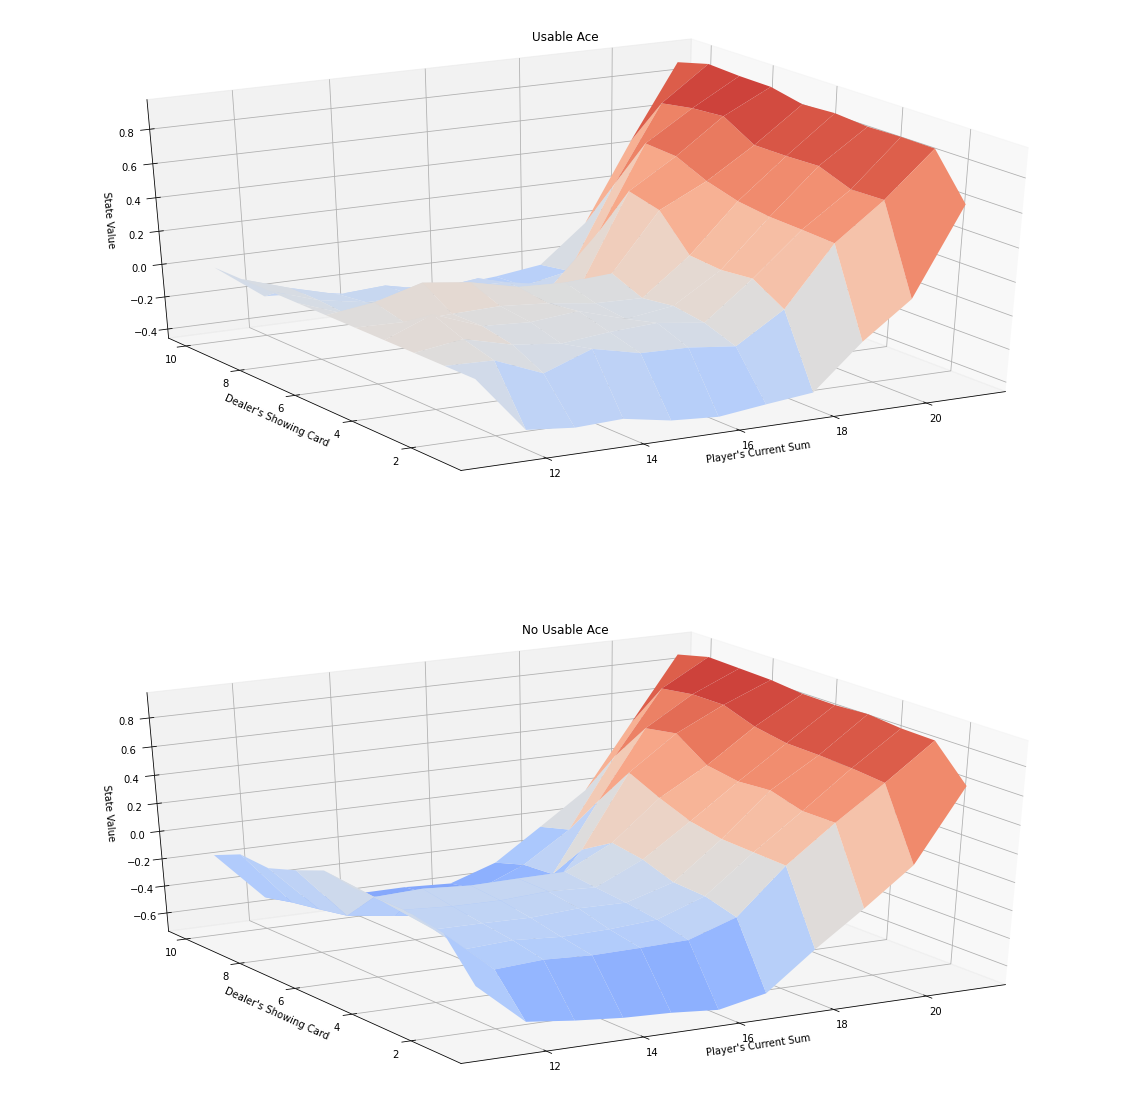

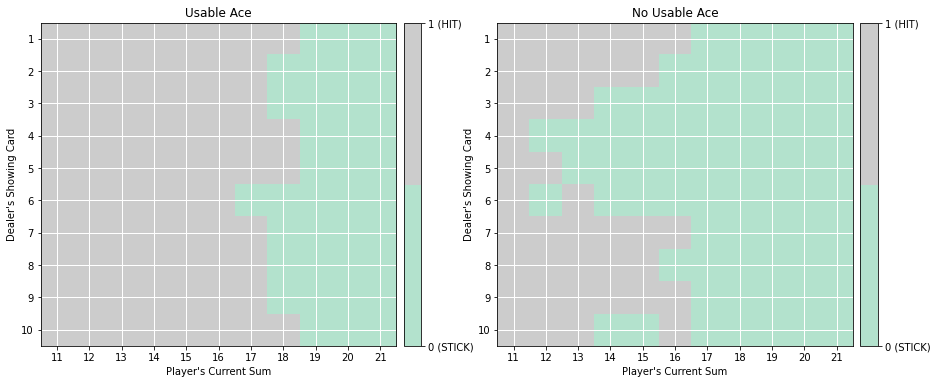

In [69]:

# plot the state-value function
plot_blackjack_values(V)
plot_policy(onpolicy)

## C.9 On-Policy Tests

Below we can see the performance of the on-policy monte carlo learning algorithm from Practical 4.

It too manages a success rate of approximately 43%.

In [112]:
wins = 0
max_episodes = 10000
for i_episode in range(max_episodes):
    state = env.reset()
    while True:
        action = np.argmax(Q_onpolicy[state])
        next_state, reward, done, info = env.step(action)
        state = next_state
        if done:
            if reward > 0:
              wins += 1
            break

print("Win Rate: {}%".format((wins/max_episodes) * 100))

Win Rate: 42.85%


## C.10 Average Rewards

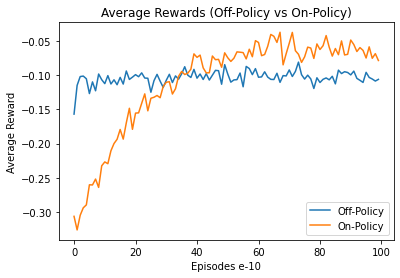

In [110]:
chunk_count = 100

def chunk_rewards(arr, size):
    return [np.mean(arr[i:i+size]) for i in range(0, len(arr), size)]

chunked_rewards = chunk_rewards(average_rewards, int(len(average_rewards)/chunk_count))
onpolicy_chunk_rewards = chunk_rewards(onpolicy_rewards, int(len(onpolicy_rewards)/chunk_count))

plt.title("Average Rewards (Off-Policy vs On-Policy)")
plt.plot(range(chunk_count), chunked_rewards, label="Off-Policy")
plt.plot(range(chunk_count), onpolicy_chunk_rewards, label ="On-Policy")
plt.ylabel("Average Reward")
plt.xlabel("Episodes e-10")
plt.legend(loc="lower right")
plt.show()